In [1]:
%load_ext autoreload
%autoreload 2

# Loading and experimenting with PDF data

In [2]:
import os
import sys
from fastcore.all import *
sys.path.insert(0, os.path.abspath('..'))

In [3]:
from docling_core.transforms.chunker import HierarchicalChunker
from sentence_transformers import SentenceTransformer
from ingest_pdf import *

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import umap

def plot_similarity_heatmap(similarities, title="Similarity Heatmap", xlabel="Meta Embeddings", ylabel="Text Embeddings"):
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.matshow(similarities, cmap='viridis')
    fig.colorbar(cax)

    ax.set_xticks(np.arange(similarities.shape[1]))
    ax.set_yticks(np.arange(similarities.shape[0]))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, pad=20)

    plt.show()


def plot_umap_projections(embeddings, labels=None, title="UMAP Projection", cmap='Spectral'):
    reducer = umap.UMAP(random_state=42)
    embeddings_2d = reducer.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    if labels is None:
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], cmap=cmap, s=50, alpha=0.7)
    else:
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap=cmap, s=50, alpha=0.7)
        plt.legend(*scatter.legend_elements(), title="Classes")

    plt.title(title, fontsize=14)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.grid(False)
    plt.show()

# Setup docling

In [5]:
# --- Configuration ---
EMBEDDING_MODEL_NAME = 'nomic-ai/modernbert-embed-base'  # Efficient local model
# EMBEDDING_MODEL_NAME = 'Alibaba-NLP/gte-modernbert-base'  # Efficient local model
CHUNK_SIZE = 1000  # Characters per chunk
CHUNK_OVERLAP = 200  # Overlap between chunks
MARKDOWN_SEPARATORS = ["\n\n", "\n", " ", ""]  # For recursive splitting
DEFAULT_COLLECTION_NAME = "pdf_rag_collection" # Default ChromaDB collection name
IMAGE_RESOLUTION_SCALE = 2.0

In [6]:
from docling.backend.pypdfium2_backend import PyPdfiumDocumentBackend
from docling.datamodel.base_models import InputFormat
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem, TextItem
from docling.datamodel.pipeline_options import (
    AcceleratorDevice,
    AcceleratorOptions,
    PdfPipelineOptions,
)
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.models.ocr_mac_model import OcrMacOptions
from docling.models.tesseract_ocr_cli_model import TesseractCliOcrOptions
from docling.models.tesseract_ocr_model import TesseractOcrOptions

In [7]:
# Docling Parse with EasyOCR
# ----------------------
pipeline_options = PdfPipelineOptions()
pipeline_options.do_ocr = True
pipeline_options.do_table_structure = True
pipeline_options.table_structure_options.do_cell_matching = True
pipeline_options.ocr_options.lang = ["en"]
pipeline_options.accelerator_options = AcceleratorOptions(
    num_threads=4, device=AcceleratorDevice.AUTO
)

# image options
pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
pipeline_options.generate_page_images = True
pipeline_options.generate_picture_images = True

doc_converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    }
)

In [8]:
pdf_source = "../sample_doc.pdf"

In [9]:
res = doc_converter.convert(pdf_source)

2025-04-06 18:27:49,772 - INFO - Going to convert document batch...
2025-04-06 18:27:49,773 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 92091623cc7be00ef4509d31dde84f5f
2025-04-06 18:27:49,798 - INFO - Loading plugin 'docling_defaults'
2025-04-06 18:27:49,800 - INFO - Registered ocr engines: ['easyocr', 'ocrmac', 'rapidocr', 'tesserocr', 'tesseract']
2025-04-06 18:27:49,873 - INFO - Accelerator device: 'mps'
2025-04-06 18:27:52,137 - INFO - Accelerator device: 'mps'
2025-04-06 18:27:53,561 - INFO - Accelerator device: 'mps'
2025-04-06 18:27:54,186 - INFO - Loading plugin 'docling_defaults'
2025-04-06 18:27:54,187 - INFO - Registered picture descriptions: ['vlm', 'api']
2025-04-06 18:27:54,187 - INFO - Processing document sample_doc.pdf
2025-04-06 18:28:28,140 - INFO - Finished converting document sample_doc.pdf in 38.39 sec.


In [10]:
markdown = res.document.export_to_markdown()

In [11]:
# print(markdown)

In [12]:
# Try to embed the images in the markdown
doc = res.document

In [13]:
 # Save markdown with embedded pictures in original text
md_filename = f"sample_doc-with-images-orig.md"
doc.save_as_markdown(md_filename, image_mode=ImageRefMode.REFERENCED)

# Hierarchical Chunking

In [14]:
# Try the HierarchicalChunke
source_titles = ["sample_doc.pdf"]
docs = [doc]
texts, metas, titles = [], [], []

# extract useful metadata for the embeds
meta_fields = [
    'parent',
    'children',
    'content_layer',
    'label',
    # 'prov',
]

nested_fields = [
    'prov'
]

chunker = HierarchicalChunker()

# Process each document in the list
for doc, title in zip(docs, source_titles):  # Pair each document with its title
    chunks = list(
        chunker.chunk(doc)
    )  # Perform hierarchical chunking and get text from chunks
    for idx, chunk in enumerate(chunks):
        itms = chunk.meta.doc_items
        meta = {'chunk_id': idx}
        for itm in itms:
            meta.update({k: str(getattr(itm, k)) for k in meta_fields})
            # add the provenance
            prov = chunk.meta.doc_items[0].prov
            for i,p in enumerate(prov):
                meta.update({
                    f'prov_{i}_page_number': p.page_no,
                    f'prov_{i}_bounding_box': str(p.bbox)
                })
        meta.update({'file': str(chunk.meta.origin.filename)})
        metas.append(meta)
        texts.append(chunk.text)
        titles.append(title)

In [15]:
metas[0]

{'chunk_id': 0,
 'parent': "cref='#/body'",
 'children': '[]',
 'content_layer': 'ContentLayer.BODY',
 'label': 'text',
 'prov_0_page_number': 1,
 'prov_0_bounding_box': "l=35.358 t=735.552 r=63.213 b=726.156 coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>",
 'file': 'sample_doc.pdf'}

In [16]:
chunk.meta.doc_items

[TextItem(self_ref='#/texts/315', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=17, bbox=BoundingBox(l=35.447, t=667.548, r=559.28, b=636.036, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 369))], orig="Disclaimer/Publisher's Note: The statements, opinions and data contained in all publications are solely those of the individual author(s) and contributor(s) and not of MDPI and/or the editor(s). MDPI and/or the editor(s) disclaim responsibility for any injury to people or property resulting from any ideas, methods, instructions or products referred to in the content.", text="Disclaimer/Publisher's Note: The statements, opinions and data contained in all publications are solely those of the individual author(s) and contributor(s) and not of MDPI and/or the editor(s). MDPI and/or the editor(s) disclaim responsibility for any injury to people or property resulting f

In [17]:
## exploration 

# itms = chunk.meta.doc_items
# itms[0].self_ref
# itms[0].parent
# itms[0].prov
# print(dict(itms[0]).keys())
# chunk.meta.origin

# meta_fields = [
#     'parent',
#     'children',
#     'content_layer',
#     'label',
#     'prov',
# ]

In [18]:
# Concatenate title and text
for i in range(len(texts)):
    texts[i] = f"{titles[i]} {texts[i]}"

# Embed the chunks

In [19]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

In [20]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = (
        attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    )
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(
        input_mask_expanded.sum(1), min=1e-9
    )


def flatten_meta(meta):
    """Flatten the meta data into a single string."""
    return "\n".join([f"{k}: {v}" for k, v in meta.items()])


In [21]:
# load the embedding models
tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
model = AutoModel.from_pretrained(EMBEDDING_MODEL_NAME)

In [22]:
# model = SentenceTransformer(EMBEDDING_MODEL_NAME)

In [29]:
# chunk in batches

bs = 10

text_embeddings = []
meta_embeddings = []

# compute the number of chunks to process, handling the last batch
num_chunks = (len(texts) // bs) + 1

import time
print(f"Embedding {len(texts)} chunks at a batch size of {bs}")

start_time = time.time()
for i in range(num_chunks):
    if i % 3 == 0:
        print(f"Embedding chunk {i+1} of {num_chunks}")

    start_idx = i * bs
    end_idx = start_idx + bs
    chunk_texts = texts[start_idx:end_idx]
    chunk_metas = metas[start_idx:end_idx]

    # flatten the meta data
    chunk_metas_str = [flatten_meta(meta) for meta in chunk_metas]

    # idea: combine the text and meta data into a single string, need to see what this does to the embeddings when visualized
    chunk_texts = [f"<TEXT>{text}</TEXT>\n<META>: {meta}</META>" for text, meta in zip(chunk_texts, chunk_metas_str)]
    # chunk_texts = [f"<META>{meta}</META>\n<TEXT>: {text}</TEXT>" for text, meta in zip(chunk_texts, chunk_metas_str)]
    # chunk_texts = [f"{text}\n<META>{meta}</META>" for text, meta in zip(chunk_texts, chunk_metas_str)]
    # chunk_texts = [f"text: {text}\nmeta:{meta}" for text, meta in zip(chunk_texts, chunk_metas_str)]

    # tokenize the texts and metas
    encoded_texts = tokenizer(chunk_texts, padding=True, truncation=True, return_tensors="pt")
    encoded_metas = tokenizer(chunk_metas_str, padding=True, truncation=True, return_tensors="pt")
    
    # embed the texts and metas
    with torch.no_grad():
        texts_outputs = model(**encoded_texts)
        metas_outputs = model(**encoded_metas)

        text_embeds = mean_pooling(texts_outputs, encoded_texts["attention_mask"])
        text_embeds = F.normalize(text_embeds, p=2, dim=1)
        meta_embeds = mean_pooling(metas_outputs, encoded_metas["attention_mask"])
        meta_embeds = F.normalize(meta_embeds, p=2, dim=1)
        # print(text_embeds.shape, meta_embeds.shape)
        text_embeddings.extend(text_embeds)
        meta_embeddings.extend(meta_embeds)

    
end_time = time.time()
print(f"Embedding took {end_time - start_time: .4f} seconds")
print(f"Average embedding time: {(end_time - start_time) / num_chunks: .4f} seconds")

Embedding 146 chunks at a batch size of 10
Embedding chunk 1 of 15
Embedding chunk 4 of 15
Embedding chunk 7 of 15
Embedding chunk 10 of 15
Embedding chunk 13 of 15
Embedding took  97.8161 seconds
Average embedding time:  6.5211 seconds


In [30]:
tembeds = torch.stack(text_embeddings)
membeds = torch.stack(meta_embeddings)
tembeds.shape, membeds.shape

(torch.Size([146, 768]), torch.Size([146, 768]))

In [31]:
# similarities = tembeds @ membeds.T
similarities = tembeds @ tembeds.T
print(similarities)

tensor([[1.0000, 0.8414, 0.7462,  ..., 0.8190, 0.3745, 0.8547],
        [0.8414, 1.0000, 0.8262,  ..., 0.7961, 0.4734, 0.8275],
        [0.7462, 0.8262, 1.0000,  ..., 0.7559, 0.6081, 0.7667],
        ...,
        [0.8190, 0.7961, 0.7559,  ..., 1.0000, 0.4642, 0.8379],
        [0.3745, 0.4734, 0.6081,  ..., 0.4642, 1.0000, 0.4887],
        [0.8547, 0.8275, 0.7667,  ..., 0.8379, 0.4887, 1.0000]])


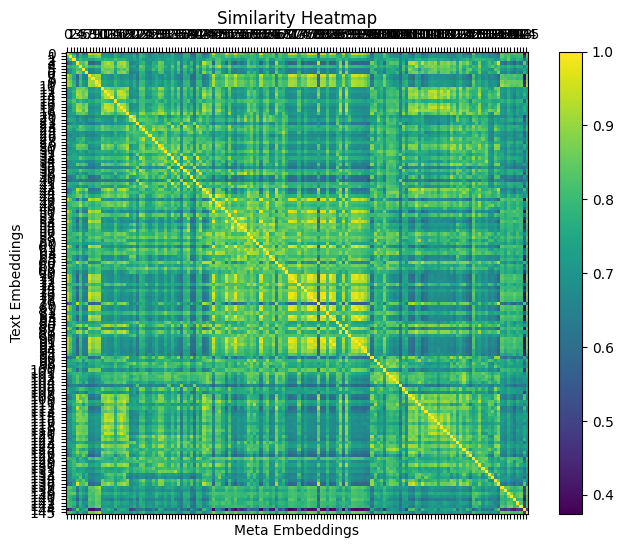

In [32]:
plot_similarity_heatmap(similarities)

/Users/cck/projects/cck-agents/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cck/projects/cck-agents/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/qm/vnrd_4ln0tv_3fv2sjtrcw040000gn/T/ipykernel_61352/4144289840.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], cmap=cmap, s=50, alpha=0.7)


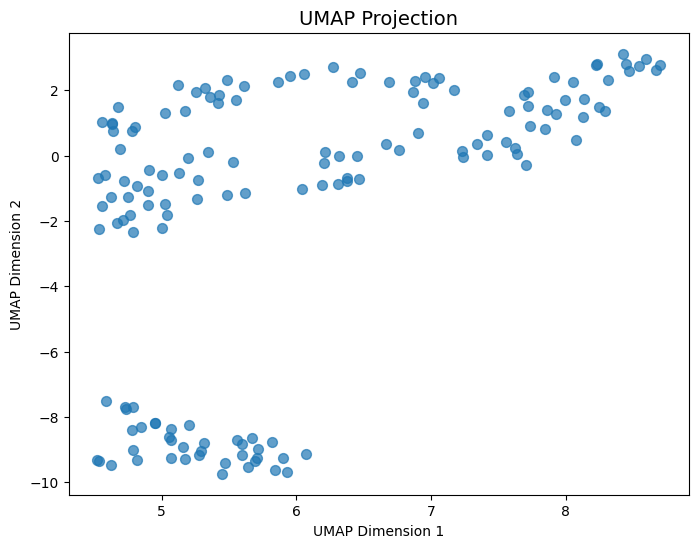

In [33]:
plot_umap_projections(tembeds)

/Users/cck/projects/cck-agents/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cck/projects/cck-agents/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/qm/vnrd_4ln0tv_3fv2sjtrcw040000gn/T/ipykernel_61352/4144289840.py:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], cmap=cmap, s=50, alpha=0.7)


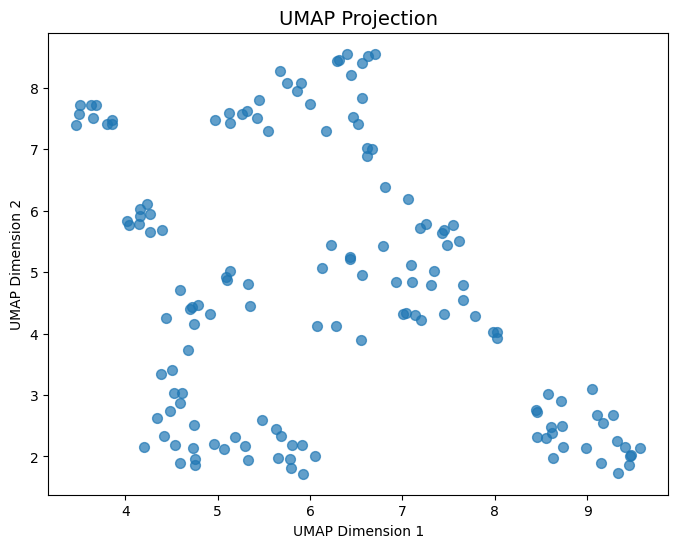

In [34]:
plot_umap_projections(membeds)